In [1]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Data preprocessing

In [2]:
y = pd.read_csv('data/y.csv').iloc[:, 0]
FS1 = pd.read_csv('data/FS1.csv', dtype=float)
PS2 = pd.read_csv('data/PS2.csv', dtype=float)

## Reduce time resolution

In [3]:
def reduce_time_resolution(df, stride):
    if stride == 1:
        return df
    
    df_reduced = []
    for i in range(0, df.shape[1], stride):
        df_reduced.append(df.iloc[:, i:i+stride].mean(axis=1))

    df_reduced = pd.concat(df_reduced, axis=1)
    # cast col names to str, otherwise sklearn classifier is not happy since we mix int and str col names
    df_reduced.columns = [str(i) for i in range(1, df_reduced.shape[1]+1)]

    return df_reduced

In [4]:
FS1 = reduce_time_resolution(FS1, stride=50)
PS2 = reduce_time_resolution(PS2, stride=500)

In [5]:
FS1.shape, PS2.shape

((2205, 12), (2205, 12))

## Train/test split

First 2k samples will be used for the training, rest for the test.

In [6]:
n = 2000

y_train = y.iloc[:n]
FS1_train = FS1.iloc[:n, :]
PS2_train = PS2.iloc[:n, :]

y_test = y.iloc[n:]
FS1_test = FS1.iloc[n:, :]
PS2_test = PS2.iloc[n:, :]

Check data distribution in training and test sets:

In [7]:
pd.concat(
    [
        y.value_counts(normalize=True).rename('all'), 
        y_train.value_counts(normalize=True).rename('train'), 
        y_test.value_counts(normalize=True).rename('test')
    ]
    , axis=1).round(2)

,all,train,test
valve condition,,,
1,0.51,0.53,0.36
0,0.49,0.47,0.64


Train set has approximatevely the same distribution of target variable as the whole dataset. However the test set has significantly less positive examples.

## Merge all features

Yes

In [8]:
def merge_features(df1, df2):
    return pd.merge(df1, df2, left_index=True, right_index=True)

X_train = merge_features(FS1_train, PS2_train)
X_test = merge_features(FS1_test, PS2_test)

No

In [8]:
# X_train = FS1_train
# X_test = FS1_test

X_train = PS2_train
X_test = PS2_test

# Base model

## Choice of the evaluation metric

Since the dataset is well balanced we could start with simple accuracy, precision or recall. Let's start with acuracy.

Check that

## Model

### Logistic regression

In [9]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [10]:
y_hat_train = clf.predict(X_train)
y_hat_train

array([1, 1, 1, ..., 0, 0, 0])

In [11]:
(y_hat_train - y_train).mean()

0.0

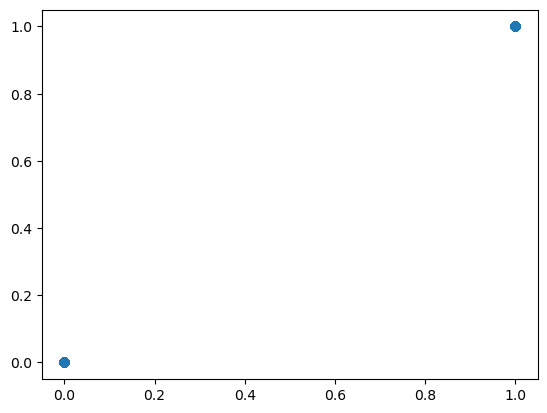

In [12]:
plt.scatter(y_train, y_hat_train)

In [13]:
clf.score(X_train, y_train)

1.0

In [14]:
clf.score(X_test, y_test)

1.0

Confusion matrix

In [15]:
y_hat_train = clf.predict(X_train)
y_hat_test = clf.predict(X_test)

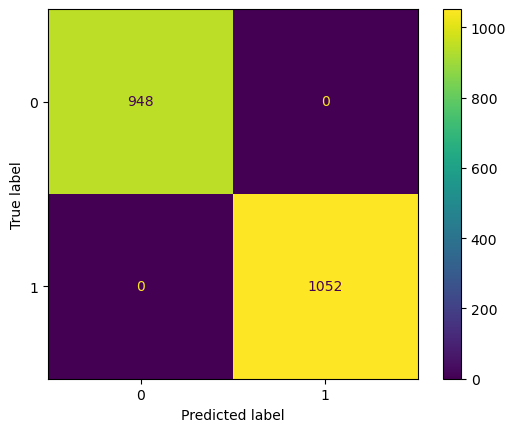

In [16]:
cm = confusion_matrix(y_train, y_hat_train, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

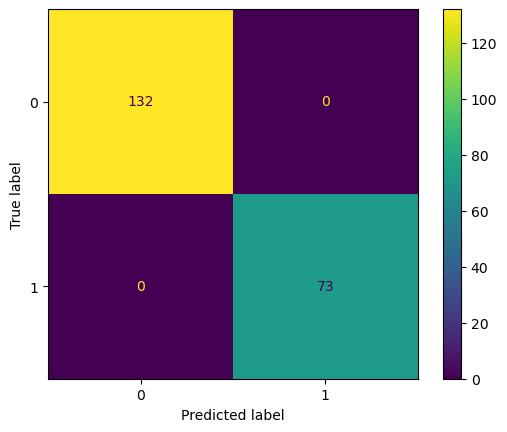

In [17]:
cm = confusion_matrix(y_test, y_hat_test, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

### SVM

In [50]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [51]:
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [52]:
clf.score(X_train, y_train)

0.9925

In [53]:
clf.score(X_test, y_test)

0.9951219512195122

# Reduce dim

## PCA

In [11]:
X = merge_features(FS1, PS2)

In [12]:
# Standardizing the features
X = StandardScaler().fit_transform(X)

In [41]:
pca = PCA(n_components=2, svd_solver='full')

In [42]:
pca.fit(X)

PCA(n_components=2, svd_solver='full')

In [43]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.56381997 0.15864157]
[172.73492059  91.62593383]


In [44]:
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [45]:
finalDf = pd.concat([principalDf, y], axis = 1)

In [46]:
finalDf

,principal component 1,principal component 2,valve condition
0,-1.407340,0.823891,1
1,-1.524358,0.912352,1
2,-1.467784,0.603511,1
3,-1.404069,0.374558,1
4,-1.603232,0.716293,1
...,...,...,...
2200,-1.507024,1.224904,1
2201,-1.552572,1.296444,1
2202,-1.587341,1.200309,1
2203,-1.676949,1.412792,1


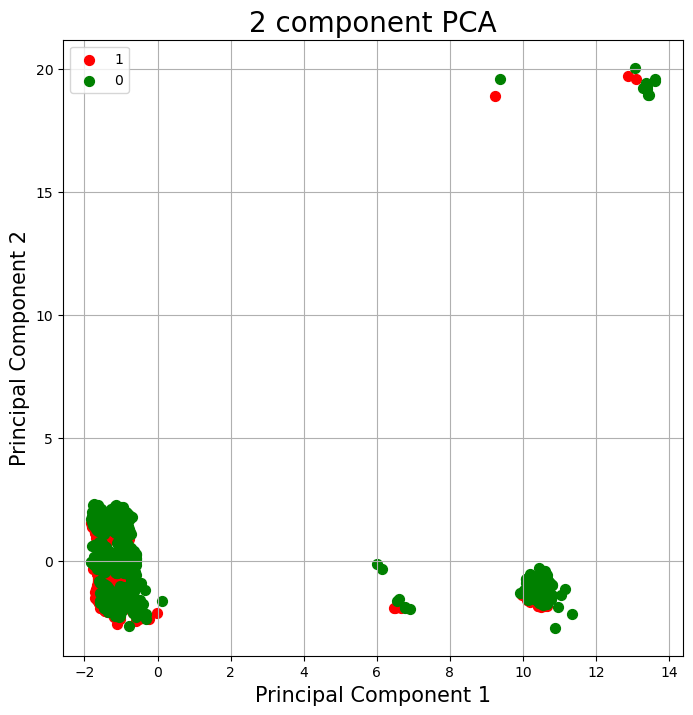

In [47]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [1, 0]
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['valve condition'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## LDA

In [21]:
clf = LinearDiscriminantAnalysis(n_components=1)

In [22]:
X_transformed = clf.fit_transform(X, y)

In [23]:
clf.score(X, y)

0.9791383219954648

In [24]:
X_transformed.shape

(2205, 1)

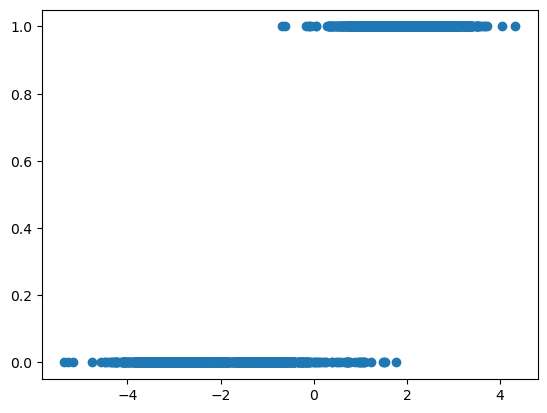

In [25]:
plt.scatter(X_transformed, y)

In [26]:
y_hat = clf.predict(X)

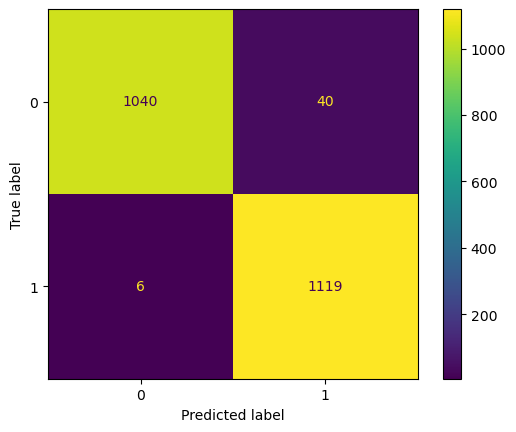

In [27]:
cm = confusion_matrix(y, y_hat, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()